In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input,GlobalMaxPool1D,Dropout
from keras.utils import plot_model
from tensorflow.keras.layers import Input,GlobalMaxPool1D,Dropout,concatenate
from tensorflow.keras.models import Model

import nltk
import re
from nltk.corpus import stopwords #corpus is collection of text
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

Using TensorFlow backend.


In [2]:
# Load train data
train = pd.read_csv('Data\\train.csv')
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
# Replace NA
train['text'] = train['text'].replace(np.nan, train['title'])
train['title'] = train['title'].replace(np.nan, train['text'])
train.isnull().sum()

id           0
title        0
author    1957
text         0
label        0
dtype: int64

In [4]:
# get label
X_train=train.drop('label',axis=1)
y_train=train['label']

In [5]:
# set vocabulary size
vo_size=500
messages=X_train.copy()
messages.reset_index(inplace=True)

In [6]:
#dataset Preprocessing
ps_title =PorterStemmer()
ps_text =PorterStemmer()
corpus_title = []
corpus_text = []
for i in range(0, len(messages)):
    print("Status: %s / %s" %(i, len(messages)), end="\r")
    
    #preproc title
    review = re.sub('[^a-zA-Z]', ' ',messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps_title.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_title.append(review)
    
    #preproc text
    review = re.sub('[^a-zA-Z]', ' ',messages['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps_text.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_text.append(review)

In [7]:
# One hot representation
onehot_rep_title = [one_hot(words, vo_size) for words in corpus_title]
onehot_rep_text = [one_hot(words, vo_size) for words in corpus_text]

In [8]:
# sequences representation
sent_length_title = 20
sent_length_text = 1000
embedded_doc_title=pad_sequences(onehot_rep_title, padding='pre', maxlen=sent_length_title)
embedded_doc_text=pad_sequences(onehot_rep_text, padding='pre', maxlen=sent_length_text)

In [9]:
# check shape 
print(len(embedded_doc_title),y_train.shape)
print(len(embedded_doc_text),y_train.shape)

20800 (20800,)
20800 (20800,)


In [10]:
# final data for NN
X_final_title=np.array(embedded_doc_title)
X_final_text=np.array(embedded_doc_text)
y_final=np.array(y_train)
print(X_final_title.shape,y_final.shape)
print(X_final_text.shape,y_final.shape)

(20800, 20) (20800,)
(20800, 1000) (20800,)


In [11]:
# Fisrt model

embedding_vector_feature_title = 10
embedding_vector_feature_text = 100

input_title = Input(shape=(sent_length_title,))
input_text = Input(shape=(sent_length_text,))

emb_title = Embedding(vo_size,embedding_vector_feature_title)(input_title)
lstm_title = LSTM(128, return_sequences=False)(emb_title)

emb_text = Embedding(vo_size,embedding_vector_feature_text)(input_text)
lstm_text = LSTM(128, return_sequences=True)(emb_text)
max_pool_text = GlobalMaxPool1D()(lstm_text)
dropout_1_text = Dropout(0.1)(max_pool_text)
dense_1_text = Dense(50, activation='relu')(dropout_1_text)
dropout_2_text = Dropout(0.1)(dense_1_text)

out = concatenate([lstm_title,dropout_2_text],axis=-1)
output=Dense(1, activation='sigmoid')(out)

model = Model(inputs=[input_title, input_text], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 100)    50000       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 1000, 128)    117248      embedding_1[0][0]                
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 128)          0           lstm_1[0][0]                     
__________________________________________________________________________________________________
input_1 (I

In [12]:
# Get model plot
plot_model(model, to_file='model_plot4.png', show_shapes=True, show_layer_names=True)

In [13]:
# train
history = model.fit(x=[X_final_title,X_final_text], y=y_final, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

C:\Anaconda\envs\py35\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16640 samples, validate on 4160 samples
Epoch 1/10
16640/16640 [==============================] - 238s 14ms/step - loss: 0.4811 - acc: 0.7551 - val_loss: 0.3242 - val_acc: 0.8695
Epoch 2/10
16640/16640 [==============================] - 238s 14ms/step - loss: 0.2507 - acc: 0.9004 - val_loss: 0.1902 - val_acc: 0.9288
Epoch 3/10
16640/16640 [==============================] - 235s 14ms/step - loss: 0.1679 - acc: 0.9398 - val_loss: 0.1868 - val_acc: 0.9267
Epoch 4/10
16640/16640 [==============================] - 234s 14ms/step - loss: 0.1369 - acc: 0.9513 - val_loss: 0.1424 - val_acc: 0.9507
Epoch 5/10
16640/16640 [==============================] - 235s 14ms/step - loss: 0.1117 - acc: 0.9600 - val_loss: 0.1227 - val_acc: 0.9560
Epoch 6/10
16640/16640 [==============================] - 235s 14ms/step - loss: 0.0943 - acc: 0.9665 - val_loss: 0.1243 - val_acc: 0.9543
Epoch 7/10
16640/16640 [==============================] - 236s 14ms/step - loss: 0.0842 - acc: 0.9701 - val_loss: 0.1

In [14]:
# load test
test = pd.read_csv('Data\\test.csv')
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [15]:
# Replace NA
test['text'] = test['text'].replace(np.nan, test['title'])
test['title'] = test['title'].replace(np.nan, test['text'])
test.isnull().sum()

id          0
title       0
author    503
text        0
dtype: int64

In [16]:
# prepare test data for NN
X_test=test
messages=X_test.copy()
messages.reset_index(inplace=True)

ps_title =PorterStemmer()
ps_text =PorterStemmer()
corpus_title = []
corpus_text = []
for i in range(0, len(messages)):
    print("Status: %s / %s" %(i, len(messages)), end="\r")
    
    #preproc title
    review = re.sub('[^a-zA-Z]', ' ',messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps_title.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_title.append(review)
    
    #preproc text
    review = re.sub('[^a-zA-Z]', ' ',messages['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps_text.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_text.append(review)

onehot_rep_title = [one_hot(words, vo_size) for words in corpus_title]
onehot_rep_text = [one_hot(words, vo_size) for words in corpus_text]

sent_length_title = 20
sent_length_text = 1000
embedded_doc_title=pad_sequences(onehot_rep_title, padding='pre', maxlen=sent_length_title)
embedded_doc_text=pad_sequences(onehot_rep_text, padding='pre', maxlen=sent_length_text)

X_final_title=np.array(embedded_doc_title)
X_final_text=np.array(embedded_doc_text)
print(X_final_title.shape)
print(X_final_text.shape)

(5200, 20)99 / 5200
(5200, 1000)


In [17]:
# predict final
y_pred_final = model.predict ([X_final_title,X_final_text])
y_prob = pd.DataFrame(y_pred_final)
y_prob['0'] = 1 - y_prob[0]
y_class = pd.DataFrame(y_prob.values.argmax(axis=-1))
y_class[0] = np.where(y_class[0]==1, 0, 1)
y_class.head()
submit = pd.concat([test['id'].reset_index(drop=True), y_class], axis=1)
submit.rename(columns={ submit.columns[1]: "label" }, inplace = True)
submit.isnull().sum()

id       0
label    0
dtype: int64

In [18]:
submit.to_csv('submit_3.csv', index=False)

In [19]:
# Save model
model.save_weights("model_multi.h5")

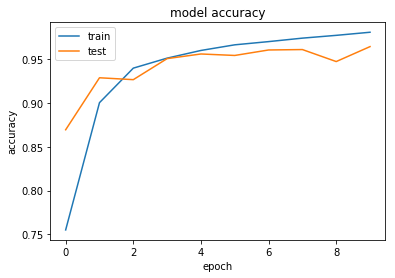

In [20]:
# summarize history for accuracy

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

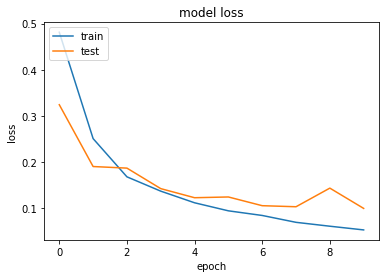

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()